In [2]:
import numpy as np
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, diags
from scipy.sparse.linalg import eigsh, eigs
from matplotlib import pyplot as plt
import h5py
import seaborn as sns
import os
oj = os.path.join

sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("pastel")

In [3]:
# load pca reduced mnist data
data = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels = np.load('myDataSets/mnist/labels.npy')

### Construct graph for dataset

In [4]:
# Construct a graph and a Gaussian kernel W with k nearest neighbors, sigma = 1, normalized so the j-th neighbor determines the unit distance
# in self tuning normalization.

# define the h function as in the paper
def h_function(a):
    return np.exp(-a)

# Function to construct a graph using k nearest neighbors and self-tuning weights.
def construct_graph(X, k, j, sigma):
    # Create a NearestNeighbors object.
    knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', metric='euclidean')

    # Fit the data to the NearestNeighbors object.
    knn.fit(X)

    # Get the k nearest neighbors for each data point.
    distances, indices = knn.kneighbors(X)
    
    # Compute self-tuning weights
    num_points = X.shape[0]
    weights = np.zeros(distances.shape)
    for i in range(num_points):
        for ii in range(k+1):
            rho_x = distances[i, ii] / distances[i, j] # Normalize distances by the j-th nearest neighbor of x
            rho_y = distances[i, ii] / distances[indices[i, ii], j]  # Normalize distances by the j-th nearest neighbor of y
            weights[i, ii] = h_function(rho_x * rho_y / sigma)

    # create self-tuning weight matrix
    row_indices = np.repeat(np.arange(num_points), k+1)
    col_indices = indices.flatten()
    weights = weights.flatten()
    W = csr_matrix((weights, (row_indices, col_indices)), shape=(num_points, num_points))

    # symmetrize the weight matrix
    W = (W + W.T) / 2

    return W, indices, distances


In [5]:
# # Example toy data for graph construction.
# data = np.array([[1, 1], [2, 2], [0.5, 0.5], [0,2]])

# # Set the number of nearest neighbors (k).
# k = 2
# j = 2
# sigma = 1

# # Create the k-nearest neighbor graph.
# W, indices, distances = construct_graph(data, k, j, sigma)

# print("Distances:")
# print(distances)

# print("Indices:")
# print(indices)

# print("Weight matrix:")
# print(W.toarray())


In [6]:
# # Example usage
# num_images = 1000  # Use a subset of images for the example
# k = 5
# j = 2
# sigma = 1
# W, indices, distances = construct_graph(data[:num_images], k, j, sigma)

# print("Distances:")
# print(distances[:2])

# print("Indices:")
# print(indices[:2])

# print("Weight matrix:")
# print(W[:2])

# # check if W is symmetric
# print(np.allclose(W.toarray(), W.toarray().T, atol=1e-8))

### Classify unlabled points using least squares regression on the labeled points in the eigenfunction embedding.

#### Compute eigenfunctions for the graph Laplacian

In [7]:

# Compute the eigenfunctions for the graph Laplacian K, given weight matrix W

# Function to compute the graph Laplacian matrix given the weight matrix W
def compute_graph_laplacian(W):
    # Compute the degree matrix D
    degrees = np.asarray(W.sum(axis=1)).flatten()
    D = diags(degrees)

    # Compute the graph Laplacian matrix L
    L = D - W

    # Compute the normalized graph Laplacian matrix L, as defined in the paper
    # L = D - W
    # D_inv_sqrt = diags(1 / np.sqrt(degrees))
    # L = D_inv_sqrt.dot(L.dot(D_inv_sqrt))

    return L

# Function to compute the eigenfunctions of the graph Laplacian matrix L
def compute_eigenfunctions(L, num_eigenvectors):
    # Compute the eigenvalues and eigenvectors of L
    eigenvalues, eigenvectors = eigsh(L, k=num_eigenvectors, which='SM')

    return eigenvalues, eigenvectors


# # Example usage
# L = compute_graph_laplacian(W)
# num_eigenvectors = 10
# eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)

# # Print the computed eigenvalues and eigenvectors
# print("Eigenvalues:")
# print(eigenvalues)
# print("Eigenvectors:")
# print(eigenvectors.shape)
# print("First two eigenvectors:")
# print(eigenvectors[:, :2])

#### Perform least squares regression on the labeled points in the eigenfunction embedding
#### and Build one-vs-all classifiers

In [8]:
# least squares regression on the labeled points in the eigenfunction embedding
# Function to compute the least squares regression coefficients
def compute_regression_coefficients(X, y):
    # Compute the regression coefficients
    # coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    # coefficients = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
    coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

    
    return coefficients

# Function to compute the predicted labels
def predict_labels(X, coefficients):
    # Compute the predicted labels
    y_pred = X.dot(coefficients)

    return y_pred

# Function to compute the classification accuracy
def compute_classification_accuracy(y_true, y_pred):
    # Compute the classification accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    return accuracy

# Function to train one-vs-all classifiers for the MNIST dataset
def train_one_vs_all_classifiers(X, y, labeled_indices, num_classes=10):
    classifiers = []

    for i in range(num_classes):
        # print(f"Training classifier for class {i}")
        y_binary = (y == i).astype(int)
        coefficients = compute_regression_coefficients(X[labeled_indices], y_binary[labeled_indices])
        classifiers.append(coefficients)

    return classifiers

# Evaluate the classifiers
def predict_one_vs_all_classifiers(classifiers, X):
    predictions = np.zeros((X.shape[0], len(classifiers)))
    for i, coefficients in enumerate(classifiers):
        predictions[:, i] = predict_labels(X, coefficients)
    return np.argmax(predictions, axis=1), predictions


# # Example usage
# X = eigenvectors
# y = labels[:num_images]
# num_labeled = 50
# indices = np.random.permutation(num_images) # Randomly selected labeled points
# labeled_indices = indices[:num_labeled]
# unlabeled_indices = indices[num_labeled:]

# classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

# y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
# accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)
# print("Classification accuracy: %.2f%%" % (accuracy * 100))


### Run experiments for MNIST data


In [9]:
# set the number of nearest neighbors (k)
k = 9

# set j, the j-th neighbor is used for noramlizing the distance
j = 4

# set sigma in Gaussian kernel, aka "local time"
sigma = 1

# set the number of eigenfunctions
num_eigenvectors = 20


### A single run of the algorithm

In [10]:
### A single run of the algorithm ###

# load pca reduced mnist data
data = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels = np.load('myDataSets/mnist/labels.npy')

# use the first num_images samples
num_total = 10000
data = data[:num_total]
labels = labels[:num_total]

# randomly choose num_labeled points as labeled data
num_labeled = 100
# indices = np.random.permutation(num_total) # Randomly selected labeled points
indices = np.arange(num_total)
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

# construct the graph
W, indices, distances = construct_graph(data, k, j, sigma)

# compute the graph Laplacian and eigenfunctions
L = compute_graph_laplacian(W)
eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)

# train the classifiers
X = eigenvectors
y = labels

classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

# evaluate the classifiers
y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)
print("Classification accuracy: %.2f%%" % (accuracy * 100))


Classification accuracy: 89.61%


In [11]:
# def single_run_mnist(num_total, num_labeled, k, j, sigma, num_eigenvectors, idx_offset=0):

#     # load pca reduced mnist data
#     data = np.load('myDataSets/mnist/pca_smoothed_data.npy')
#     labels = np.load('myDataSets/mnist/labels.npy')

#     # use the first num_total samples
#     data = data[idx_offset:idx_offset+num_images]
#     labels = labels[idx_offset:idx_offset+num_images]

#     # randomly choose num_labeled points as labeled data
#     indices = np.random.permutation(num_images) # Randomly selected labeled points
#     # indices = np.arange(num_images)
#     labeled_indices = indices[:num_labeled]
#     unlabeled_indices = indices[num_labeled:]

#     # construct the graph
#     W, indices, distances = construct_graph(data, k, j, sigma)

#     # compute the graph Laplacian and eigenfunctions
#     L = compute_graph_laplacian(W)
#     eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)

#     # train the classifiers
#     X = eigenvectors
#     y = labels

#     classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

#     # evaluate the classifiers
#     y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
#     accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)
#     print("Error rate: %.2f%%" % ((1-accuracy) * 100))

#     return accuracy
    
# def get_num_labeled_list(num_images):
#     return [x for x in [50, 100, 500, 1000, 5000, 10000, 50000] if x < num_images]

# def save_h5():
#     with h5py.File('total{}.h5'.format(num_images), 'w') as hf:
#         hf.create_dataset("error_rate_array",  data=error_rate_array)
#         hf.create_dataset("num_labeled_list",  data=num_labeled_list)
#         hf.create_dataset("num_eigenvectors_list",  data=num_eigenvectors_list)
#         hf.create_dataset("num_splits",  data=num_splits)

In [12]:
# ### Run the algorithm multiple times and average the results ###

# num_splits = 5
# num_images_list = [1000, 10000, 30000]
# num_eigenvectors_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200, 250]


# for i_nimg, num_images in enumerate(num_images_list):
#     num_labeled_list = get_num_labeled_list(num_images)
#     error_rate_array = np.zeros((len(num_labeled_list), len(num_eigenvectors_list), num_splits))
#     for i_nlb, num_labeled in enumerate(num_labeled_list):
#         for i_nvec, num_eigenvectors in enumerate(num_eigenvectors_list):
#             print('-----Number of images: %d, Number of labeled points: %d, Number of eigenvectors: %d-----' % (num_images, num_labeled, num_eigenvectors))
#             for i_split in range(num_splits):
#                 error_rate_array[i_nlb, i_nvec, i_split] = 1 - single_run_mnist(num_images, num_labeled, k, j, sigma, num_eigenvectors)


#     save_h5()

#### helper functions

In [13]:
# function to construct graph and get graph Laplacian, given data, k, j, and sigma
def get_graph_laplacian(data, k, j, sigma):
    # construct the graph
    W, indices, distances = construct_graph(data, k, j, sigma)

    # compute the graph Laplacian
    L = compute_graph_laplacian(W)

    return L


# function to traing and evaluate SSL classifier, given X (eigenfunction embedding), y (labels), labeled_indices, unlabeled_indices
def train_and_evaluate(X, y, labeled_indices, unlabeled_indices):
    classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

    # evaluate the classifiers
    y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
    accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)

    return accuracy

In [14]:
# create list of splits of labeled and unlabeled data
def create_splits(num_images, num_splits, num_labeled):
    labeled_indices_list = []
    unlabeled_indices_list = []
    for split in range(num_splits):
        indices = np.random.permutation(num_images) # Randomly selected labeled points
        labeled_indices = indices[:num_labeled]
        unlabeled_indices = indices[num_labeled:]
        labeled_indices_list.append(labeled_indices)
        unlabeled_indices_list.append(unlabeled_indices)

    return labeled_indices_list, unlabeled_indices_list

# function to cross validate the number of eigenfunctions
def cross_validate_num_eigenvectors(L, labeled_indices_list, unlabeled_indices_list, data, labels, num_eigenvectors_list):
    error_rate_array = np.zeros((len(num_eigenvectors_list), len(labeled_indices_list)))
    for i_nvec, num_eigenvectors in enumerate(num_eigenvectors_list):
        # compute eigenfunctions
        eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)
        X, y = eigenvectors, labels

        for split, (labeled_indices, unlabeled_indices) in enumerate(zip(labeled_indices_list, unlabeled_indices_list)):
            accuracy = train_and_evaluate(X, y, labeled_indices, unlabeled_indices)
            error_rate_array[i_nvec, split] = 1 - accuracy
            print("# of images: {}, # of labeled: {}, Number of eigenfunctions: {}, Split {}, Error rate: {:.2f}%".format(len(labels), len(labeled_indices), num_eigenvectors, split, (1-accuracy) * 100))

    return error_rate_array
    
def get_num_labeled_list(num_images):
    return [x for x in [50, 100, 500, 1000, 5000, 10000, 50000] if x < num_images]
    

#### Groups of experiments

In [15]:
# load pca reduced mnist data
data_full = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels_full = np.load('myDataSets/mnist/labels.npy')

Cross validate number of eigenfunctions

In [16]:
num_images_list = [1000, 10000, 30000]


# number of different splits of labeled and unlabeled data
num_splits = 10

# number of eigenfunctions
num_eigenvectors_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200, 250]



In [17]:

def run_with_diff_num_eigenfunctions(out_dir, num_total_list, data_full, labels_full):
    # run graph SSL with different number of labeled points and different number of eigenfunctions
    for num_total in num_total_list:
        data = data_full[:num_total]
        labels = labels_full[:num_total]
        num_labeled_list = get_num_labeled_list(num_total)

        L = get_graph_laplacian(data, k, j, sigma)
        
        error_rate_array = np.zeros((len(num_labeled_list), len(num_eigenvectors_list), num_splits))
        
        for i_nlb, num_labeled in enumerate(num_labeled_list):
            # create split of labeled and unlabeled data
            labeled_indices_list, unlabeled_indices_list = create_splits(num_total, num_splits, num_labeled)

            # cross validate to choose the best number of eigenfunctions
            error_rate_array[i_nlb] = cross_validate_num_eigenvectors(L, labeled_indices_list, unlabeled_indices_list, data, labels, num_eigenvectors_list)

        # save error rate array and parameters in one h5 file
        with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'w') as hf:
            hf.create_dataset("error_rate_array",  data=error_rate_array)
            hf.create_dataset("num_labeled_list",  data=num_labeled_list)
            hf.create_dataset("num_eigenvectors_list",  data=num_eigenvectors_list)
            hf.create_dataset("num_splits",  data=num_splits)


In [18]:
# run_with_diff_num_eigenfunctions('.', num_images_list, data_full, labels_full)

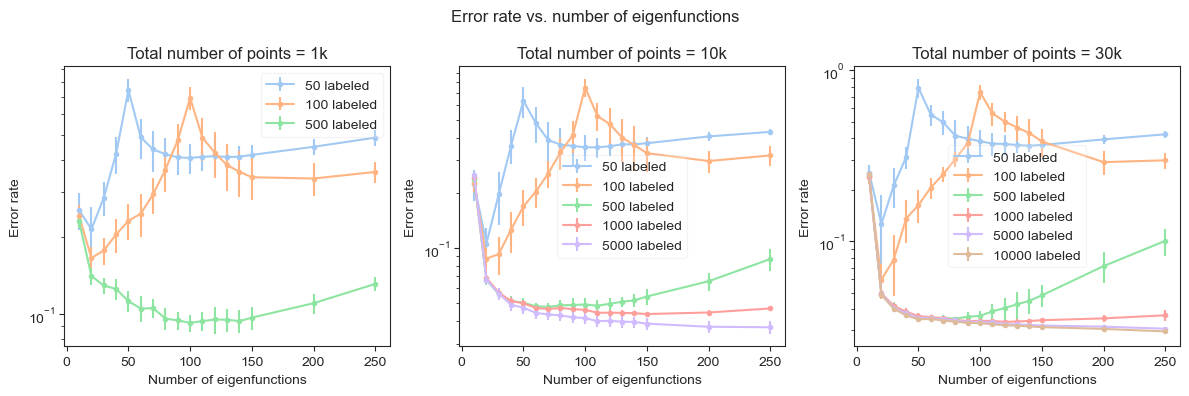

In [19]:
# plot the error rate vs. number of eigenfunctions for each number of labeled points and each number of images
# load error rate array and parameters from h5 file
# group by number of images

# create figure and axes
def plot_error_rate_vs_num_eigenvectors(out_dir, num_total_list):
    fig, axes = plt.subplots(1, len(num_total_list), figsize=(12, 4))
    for num_total, ax in zip(num_total_list, axes):
        with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'r') as hf:
            error_rate_array = hf['error_rate_array'][:]
            num_labeled_list = hf['num_labeled_list'][:]
            num_eigenvectors_list = hf['num_eigenvectors_list'][:]
            num_splits = hf['num_splits'][()]

        error_rate_mean = np.mean(error_rate_array, axis=2)
        error_rate_std = np.std(error_rate_array, axis=2)

        for i_nlb, num_labeled in enumerate(num_labeled_list):
            ax.errorbar(num_eigenvectors_list, error_rate_mean[i_nlb], yerr=error_rate_std[i_nlb], fmt='.-', label="{} labeled".format(num_labeled))

        ax.set_xlabel("Number of eigenfunctions")
        ax.set_ylabel("Error rate")
        # set log scale for y axis
        ax.set_yscale('log')
        ax.legend(fancybox=True, framealpha=0.2)
        ax.set_title('Total number of points = {}'.format(f"{num_total//1000}k" if num_total >= 1000 else num_total))

    fig.suptitle('Error rate vs. number of eigenfunctions')
    fig.tight_layout()
    return fig

fig = plot_error_rate_vs_num_eigenvectors('.', num_images_list)

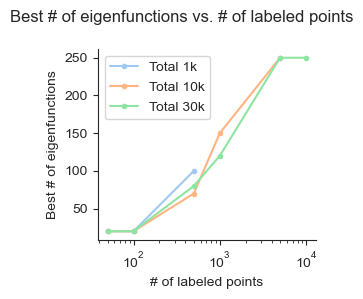

In [20]:
# plot how best number of eigenfunctions change with number of labeled points and number of images
# load error rate array and parameters from h5 file

def plot_beat_num_eigenvectors_vs_num_labeled(out_dir, num_total_list):
    # create figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    for num_total in num_total_list:
        with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'r') as hf:
            error_rate_array = hf['error_rate_array'][:]
            num_labeled_list = hf['num_labeled_list'][:]
            num_eigenvectors_list = hf['num_eigenvectors_list'][:]
            num_splits = hf['num_splits'][()]

        error_rate_mean = np.mean(error_rate_array, axis=2)
        error_rate_std = np.std(error_rate_array, axis=2)

        best_num_eigenvectors = num_eigenvectors_list[np.argmin(error_rate_mean, axis=1)]
        ax.plot(num_labeled_list, best_num_eigenvectors, '.-', label='Total {}'.format(f"{num_total//1000}k" if num_total >= 1000 else num_total))

        ax.set_xlabel("# of labeled points")
        ax.set_ylabel("Best # of eigenfunctions")
        # set log scale for x axis
        ax.set_xscale('log')
        ax.legend()

    sns.despine()
    fig.suptitle('Best # of eigenfunctions vs. # of labeled points')
    fig.tight_layout()

    plt.show()
    return fig

fig = plot_beat_num_eigenvectors_vs_num_labeled('.', num_images_list)


Run with best number of eigenfunctions

In [21]:
def run_with_given_num_eigenvectors(L, labeled_indices_list, unlabeled_indices_list, data, labels, num_eigenvectors):
    error_rate_array = np.zeros(len(labeled_indices_list))
    # compute eigenfunctions
    eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)
    X, y = eigenvectors, labels

    for split, (labeled_indices, unlabeled_indices) in enumerate(zip(labeled_indices_list, unlabeled_indices_list)):
        accuracy = train_and_evaluate(X, y, labeled_indices, unlabeled_indices)
        error_rate_array[split] = 1 - accuracy
        print("# of images: {}, # of labeled: {}, Number of eigenfunctions: {}, Split {}, Error rate: {:.2f}%".format(len(labels), len(labeled_indices), num_eigenvectors, split, (1-accuracy) * 100))

    return error_rate_array

In [22]:

# run SSL classifier with the best number of eigenfunctions


def run_with_best_num_eigenfunctions(out_dir, num_total_list, data_full, labels_full, idx_offset):

    for num_total in num_total_list:
        # use the 30k-60k samples
        data = data_full[idx_offset:idx_offset+num_total]
        labels = labels_full[idx_offset:idx_offset+num_total]

        with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'r') as hf:
            error_rate_array = hf['error_rate_array'][:]
            num_labeled_list = hf['num_labeled_list'][:]
            num_eigenvectors_list = hf['num_eigenvectors_list'][:]
            num_splits = hf['num_splits'][()]

        # find the best number of eigenfunctions for each number of labeled points
        error_rate_mean = np.mean(error_rate_array, axis=2)
        best_num_eigenvectors_list = []
        for i_nlb, num_labeled in enumerate(num_labeled_list):
            best_num_eigenvectors = num_eigenvectors_list[np.argmin(error_rate_mean[i_nlb])]
            best_num_eigenvectors_list.append(best_num_eigenvectors)
            print("Number of labeled: {}, Best number of eigenfunctions: {}".format(num_labeled, best_num_eigenvectors))


        ### run graph SSL ###
        # compute the graph Laplacian
        L = get_graph_laplacian(data, k, j, sigma)
        error_rate_array = np.zeros((len(num_labeled_list), num_splits))

        num_labeled_list = get_num_labeled_list(num_total)
        for i_nlb, num_labeled in enumerate(num_labeled_list):
            # create split of labeled and unlabeled data
            labeled_indices_list, unlabeled_indices_list = create_splits(num_total, num_splits, num_labeled)

            # for each number of labeled points, train the classifiers with the best number of eigenfunctions
            best_num_eigenvectors = best_num_eigenvectors_list[i_nlb]
            
            # run the classifier with the best number of eigenfunctions
            error_rate_array[i_nlb] = run_with_given_num_eigenvectors(L, labeled_indices_list, unlabeled_indices_list, data, labels, best_num_eigenvectors)

        # save the error rate array and parameters to h5 file
        with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'a') as hf:
            # delete the dataset if it already exists
            if 'test_error_rate_array' in hf:
                del hf['test_error_rate_array']
            hf.create_dataset('test_error_rate_array', data=error_rate_array)




In [23]:

# run the classifier with the best number of eigenfunctions
# run_with_best_num_eigenfunctions('.', num_images_list, data_full, labels_full, idx_offset=30000)

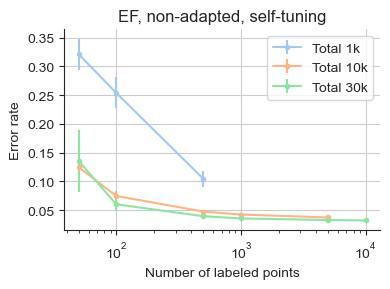

In [24]:
# plot the error rate vs. number of labeled points for all numbers of images, using the best number of eigenfunctions for each point

def plot_error_rate_vs_num_labeled(out_dir, num_total_list):
    # create figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_palette("pastel")
    for num_total in num_total_list:
        with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'r') as hf:
            error_rate_array = hf['test_error_rate_array'][:]
            num_labeled_list = hf['num_labeled_list'][:]

        error_rate_mean = np.mean(error_rate_array, axis=1)
        error_rate_std = np.std(error_rate_array, axis=1)

        ax.errorbar(num_labeled_list, error_rate_mean, yerr=error_rate_std, fmt='.-', label="Total {}".format(f"{num_total//1000}k" if num_total >= 1000 else num_total))

    ax.set_xlabel("Number of labeled points")
    ax.set_ylabel("Error rate")
    # set log scale for x axis
    ax.set_xscale('log')
    ax.legend()
    ax.grid('on')
    ax.set_title('EF, non-adapted, self-tuning')
    sns.despine()
    fig.tight_layout()
    # fig.savefig('error_rate_vs_num_labeled_points.png', dpi=300)
    return fig, ax

fig, ax = plot_error_rate_vs_num_labeled('.', num_images_list)

## Science News Dataset

In [29]:
# what do we need
# 1. data
# 2. labels
# 3. number of labeled points (a function)
# 4. number of eigenfunctions (a list)
# 5. number of splits (a number)
# 6. number of total points (a list)
# 7. k (a number)
# 8. j (a number)
# 9. sigma (a number)
# 10. out_dir (a string)

# what experiments are needed
# 1. run graph SSL with different number of labeled points and different number of eigenfunctions
# 2. run graph SSL with different number of labeled points and best number of eigenfunctions

# what plots are needed
# 1. error rate vs number of eigenfunctions with different number of labeled points, for each number of total points
# 2. Best number of eigenfunctions vs number of labeled points
# 3. error rate vs number of labeled points with best number of eigenfunctions

In [30]:
# define all the variables needed
data_full = np.load('myDataSets/science/data.npy')
labels_full = np.load('myDataSets/science/labels.npy')
num_total_list = [200, 500, 1000]
def get_num_labeled_list(num_total):
    return [x for x in [20, 50, 100, 200, 500] if x < num_total]
num_eigenvectors_list = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30, 35, 40, 45, 50]
num_splits = 20
k = 9
j = 4
sigma = 1
out_dir = 'science'
os.makedirs(out_dir, exist_ok=True)



In [37]:
# cross validate different number of eigenfunctions
run_with_diff_num_eigenfunctions(out_dir, num_total_list, data_full, labels_full)

# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 0, Error rate: 80.56%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 1, Error rate: 80.56%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 2, Error rate: 81.11%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 3, Error rate: 81.67%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 4, Error rate: 80.00%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 5, Error rate: 82.22%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 6, Error rate: 80.00%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 7, Error rate: 90.56%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 8, Error rate: 81.67%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 1, Split 9, Error rate: 92.78%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 2, Split

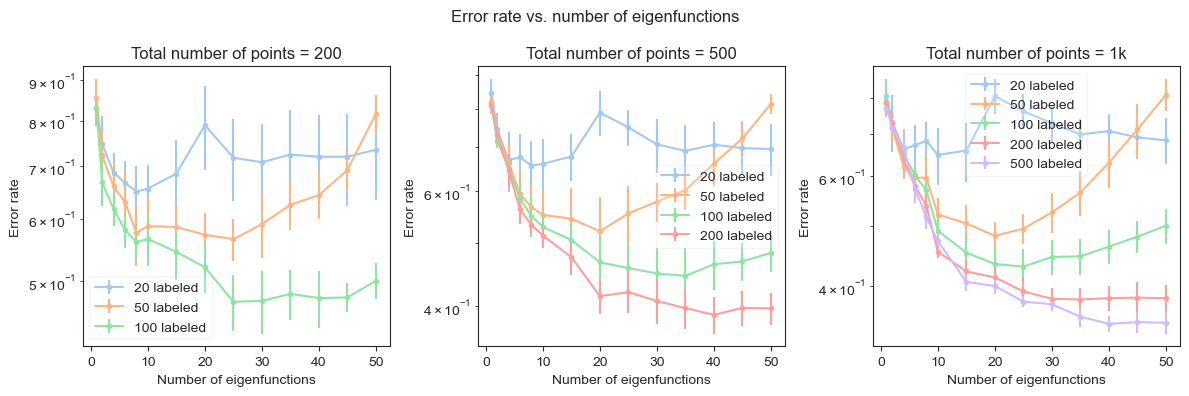

In [38]:
fig = plot_error_rate_vs_num_eigenvectors(out_dir, num_total_list)

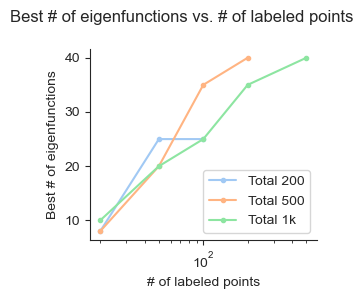

In [39]:
fig = plot_beat_num_eigenvectors_vs_num_labeled(out_dir, num_total_list)

In [43]:
# run SSL classifier with the best number of eigenfunctions
run_with_best_num_eigenfunctions(out_dir, num_total_list, data_full, labels_full, idx_offset=0)

Number of labeled: 20, Best number of eigenfunctions: 8
Number of labeled: 50, Best number of eigenfunctions: 25
Number of labeled: 100, Best number of eigenfunctions: 25
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 0, Error rate: 57.22%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 1, Error rate: 76.11%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 2, Error rate: 61.67%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 3, Error rate: 56.67%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 4, Error rate: 57.78%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 5, Error rate: 56.67%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 6, Error rate: 71.11%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 7, Error rate: 68.33%
# of images: 200, # of labeled: 20, Number of eigenfunctions: 8, Split 8, Error rate:

Text(0.5, 1.0, 'EF, non-adapted, self-tuning, Science News')

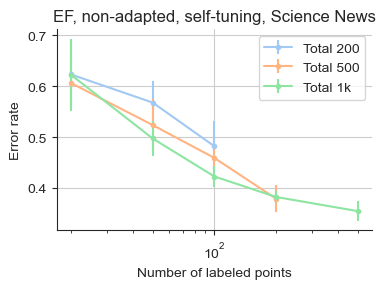

In [44]:
fig, ax = plot_error_rate_vs_num_labeled(out_dir, num_total_list)
ax.set_title('EF, non-adapted, self-tuning, Science News')

### Function adapted

In [25]:
# what to do
# implemet the function to compute c_i, from homonic classifer
# add c_i as extra coordinates, built a new weight matrix. Do the same thing as before

In [26]:
# function to compute new W, given X (data), c_i (extra coordinates),
# indices (of nearest neighbors), j (j-th neighbor in self-tuning normalization), sigma (local time)
# and beta (scaling factor for c_i)

def function_adapted_W(X, c, indices, j, sigma, beta):
    # add c_i as extra coordinates to X
    # average norm of original spatial coordinates
    avg_norm_X = np.mean(np.linalg.norm(X, axis=0))
    # average norm of c_i
    avg_norm_c = np.mean(np.linalg.norm(c, axis=0))
    # normalize c_i, with multiplication factor beta
    print('avg_norm_X: ', avg_norm_X, 'avg_norm_c: ', avg_norm_c, 'beta: ', beta)
    c = c * avg_norm_X / avg_norm_c * beta
    X = np.concatenate((X, c), axis=1)

    # Compute self-tuning weights
    num_points = X.shape[0]
    weights = np.zeros(indices.shape)
    for i in range(num_points):
        for ii in range(k+1):
            rho_x = np.linalg.norm(X[i] - X[indices[i, ii]]) / np.linalg.norm(X[i] - X[indices[i, j]]) # Normalize by the distance between x and the j-th nearest neighbor of x
            rho_y = np.linalg.norm(X[i] - X[indices[i, ii]]) / np.linalg.norm(X[indices[i, ii]] - X[indices[indices[i, ii],j]]) # Normalize by the distance between y and the j-th nearest neighbor of y
            weights[i, ii] = h_function(rho_x * rho_y / sigma)

    # create self-tuning weight matrix
    row_indices = np.repeat(np.arange(num_points), k+1)
    col_indices = indices.flatten()
    weights = weights.flatten()
    W = csr_matrix((weights, (row_indices, col_indices)), shape=(num_points, num_points))

    # symmetrize the weight matrix
    W = (W + W.T) / 2

    return W

In [27]:
# function to compute random walk matrix K from W
def random_walk_K(W):
    # compute the diagonal matrix D
    D = np.diag(np.array(W.sum(axis=1)).flatten())
    # compute the random walk matrix K
    K = np.linalg.inv(D) @ W

    return K

In [28]:
# function of hamonic classifier
def harmonic_classifier_one_vs_all(y, labeled_indices, K, num_classes=10, steps=250):
    chi_lab_array = np.zeros((len(y), num_classes))
    for i_lb in range(num_classes):
        y_binary = (y == i_lb).astype(int)
        chi_lab = np.zeros(y_binary.shape)
        chi_lab[labeled_indices] = y_binary[labeled_indices]

        for i in range(steps):
            chi_lab = K @ chi_lab
            chi_lab[labeled_indices] = y_binary[labeled_indices]

        chi_lab_array[:, i_lb] = chi_lab

    return chi_lab_array


In [29]:
### A single run of the function-adapted algorithm ###
# set the number of nearest neighbors (k)
k = 9

# set j, the j-th neighbor is used for noramlizing the distance
j = 4

# set sigma in Gaussian kernel, aka "local time"
sigma = 1

# set the number of eigenfunctions
num_eigenvectors = 30

# set beta
beta = 1

# load pca reduced mnist data
data = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels = np.load('myDataSets/mnist/labels.npy')

# use the first num_images samples
num_total = 10000
data = data[:num_total]
labels = labels[:num_total]

# randomly choose num_labeled points as labeled data
num_labeled = 100
# indices = np.random.permutation(num_total) # Randomly selected labeled points
indices = np.arange(num_total)
labeled_indices = indices[:num_labeled]
unlabeled_indices = indices[num_labeled:]

# construct the graph
W, indices, distances = construct_graph(data, k, j, sigma)
W_old = W.copy()

# compute random walk matrix K
K = random_walk_K(W)

# run harmonic classifier
c = harmonic_classifier_one_vs_all(labels, labeled_indices, K, steps=250)

# compute the function-adapted weight matrix
W = function_adapted_W(data, c, indices, j, sigma, beta=1)

# compute the graph Laplacian and eigenfunctions
L = compute_graph_laplacian(W)
eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)

# train the classifiers
X = eigenvectors
y = labels

classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

# evaluate the classifiers
y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)
print("Classification accuracy: %.2f%%" % (accuracy * 100))


KeyboardInterrupt: 

In [ ]:
def single_run(data, labels, num_labeled, k, j, sigma, beta, steps, num_eigenvectors):
    num_total = data.shape[0]
    # randomly choose num_labeled points as labeled data
    indices = np.random.permutation(num_total) # Randomly selected labeled points
    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]

    # construct the graph
    W, indices, distances = construct_graph(data, k, j, sigma)
    W_old = W.copy()

    # compute random walk matrix K
    K = random_walk_K(W)

    # run harmonic classifier
    c = harmonic_classifier_one_vs_all(labels, labeled_indices, K, steps=steps)

    # compute the function-adapted weight matrix
    W_new = function_adapted_W(data, c, indices, j, sigma, beta=beta)

    accuracy_list = []
    if type(num_eigenvectors) == int:
        num_eigenvectors = [num_eigenvectors] * 2
    for method, W, n_vec in zip(['Non-adapted', 'Func-adapted'], [W_old, W_new], num_eigenvectors):
        # compute the graph Laplacian and eigenfunctions
        L = compute_graph_laplacian(W)
        eigenvalues, eigenvectors = compute_eigenfunctions(L, n_vec)

        # train the classifiers
        X = eigenvectors
        y = labels

        classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

        # evaluate the classifiers
        y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
        accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)
        print("Method: {}, Classification accuracy: {:.2f}%".format(method, accuracy * 100))
        accuracy_list.append(accuracy)

    return accuracy_list

def get_num_labeled_list(num_images):
    return [x for x in [50, 100, 500, 1000, 5000, 10000, 50000] if x < num_images]


# Example
# # load pca reduced mnist data
# data = np.load('myDataSets/mnist/pca_smoothed_data.npy')
# labels = np.load('myDataSets/mnist/labels.npy')

# # use the first num_images samples
# num_total = 10000
# data = data[:num_total]
# labels = labels[:num_total]

# k = 9
# j = 4
# sigma = 1
# beta = 1
# steps = 250
# num_eigenvectors = 20
# num_labeled = 100

# single_run(data, labels, num_labeled, k, j, sigma, beta, steps, num_eigenvectors)





In [ ]:
# iterate over different number of eigenvectors
num_total = 10000
num_labeled_list = [100]
num_eigenvectors_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 200, 250]

# load pca reduced mnist data
data_full = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels_full = np.load('myDataSets/mnist/labels.npy')
data = data_full[:num_total]
labels = labels_full[:num_total]

num_splits = 5

# set algorithm parameters
k = 9
j = 4
sigma = 1
beta = 1
steps = 250

error_rate_array = np.zeros((len(num_labeled_list), len(num_eigenvectors_list), num_splits))
for i_nlb, num_labeled in enumerate(num_labeled_list):
    for i_nvec, number_of_eigenvectors in enumerate(num_eigenvectors_list):
        for i_split in range(num_splits):
            print("Number of labeled: {}, Number of eigenvectors: {}, Split: {}".format(num_labeled, number_of_eigenvectors, i_split))
            error_rate_array[i_nlb, i_nvec, i_split] = 1 - single_run(data, labels, num_labeled, k, j, sigma, beta, steps, number_of_eigenvectors)[1]

# save the results to h5 file
out_dir = 'mnist/FA'
with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'w') as f:
    f.create_dataset('num_labeled_list', data=np.array(num_labeled_list))
    f.create_dataset('num_eigenvectors_list', data=np.array(num_eigenvectors_list))
    f.create_dataset('error_rate_array', data=error_rate_array)
    f.create_dataset('num_splits', data=np.array(num_splits))





Number of labeled: 100, Number of eigenvectors: 10, Split: 0
avg_norm_X:  12994.905153679154 avg_norm_c:  12.624393498130232 beta:  1
Method: Non-adapted, Classification accuracy: 74.82%
Method: Func-adapted, Classification accuracy: 74.89%
Number of labeled: 100, Number of eigenvectors: 10, Split: 1
avg_norm_X:  12994.905153679154 avg_norm_c:  12.544972479430196 beta:  1
Method: Non-adapted, Classification accuracy: 78.15%
Method: Func-adapted, Classification accuracy: 78.37%
Number of labeled: 100, Number of eigenvectors: 10, Split: 2


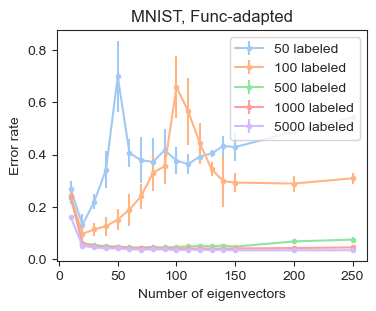

In [ ]:
# plot the error rate vs. number of eigenvectors
out_dir = 'mnist/FA'
with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'r') as f:
    num_labeled_list = f['num_labeled_list'][:]
    num_eigenvectors_list = f['num_eigenvectors_list'][:]
    error_rate_array = f['error_rate_array'][:]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for i_nlb, num_labeled in enumerate(num_labeled_list):
    error_rate_mean = np.mean(error_rate_array[i_nlb], axis=1)
    error_rate_std = np.std(error_rate_array[i_nlb], axis=1)
    ax.errorbar(num_eigenvectors_list, error_rate_mean, yerr=error_rate_std, fmt='.-', label="{} labeled".format(num_labeled))
    
ax.set_xlabel('Number of eigenvectors')
ax.set_ylabel('Error rate')
ax.set_title('MNIST, Func-adapted')
ax.legend()

In [ ]:
# find the best number of eigenvectors for function-adapted
best_num_eigenvectors = {}
for i_nlb, num_labeled in enumerate(num_labeled_list):
    error_rate_mean = np.mean(error_rate_array[i_nlb], axis=1)
    best_num_eigenvectors[num_labeled] = num_eigenvectors_list[np.argmin(error_rate_mean)]
best_num_eigenvectors_FA = best_num_eigenvectors

# print
for num_labeled in num_labeled_list:
    print("Number of labeled: {}, Best number of eigenvectors: {}".format(num_labeled, best_num_eigenvectors[num_labeled]))

# Best number of eigenvectors for each num_labeled from the non-adapted experiment
best_num_eigenvectors = {50: 20, 100: 20, 500: 70, 1000: 150, 5000: 250}
best_num_eigenvectors_NA = best_num_eigenvectors


Number of labeled: 50, Best number of eigenvectors: 20
Number of labeled: 100, Best number of eigenvectors: 20
Number of labeled: 500, Best number of eigenvectors: 70
Number of labeled: 1000, Best number of eigenvectors: 140
Number of labeled: 5000, Best number of eigenvectors: 150


In [32]:
# iterate over different number of labeled points, compare the classification accuracy of the function-adapted algorithm and the non-adapted algorithm
num_total = 10000

# load pca reduced mnist data
data_full = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels_full = np.load('myDataSets/mnist/labels.npy')
data = data_full[30000:30000+num_total]
labels = labels_full[30000:30000+num_total]

# get the list of number of labeled points
num_labeled_list = get_num_labeled_list(num_total)
num_splits = 5

# set algorithm parameters
k = 9
j = 4
sigma = 1
beta = 1
steps = 250

error_rate_NA_array = np.zeros((len(num_labeled_list), num_splits))
error_rate_FA_array = np.zeros((len(num_labeled_list), num_splits))
for i_nlb, num_labeled in enumerate(num_labeled_list):
    num_eigenvectors = [best_num_eigenvectors_NA[num_labeled], best_num_eigenvectors_FA[num_labeled]]
    print("Number of labeled points: {}, Number of eigenfunctions: {}".format(num_labeled, num_eigenvectors))
    for split in range(num_splits):
        accuracy_NA, accuracy_FA = single_run(data, labels, num_labeled, k, j, sigma, beta, steps, num_eigenvectors)
        error_rate_NA_array[i_nlb, split] = 1 - accuracy_NA
        error_rate_FA_array[i_nlb, split] = 1 - accuracy_FA

        


    

Number of labeled points: 50, Number of eigenfunctions: [20, 20]
avg_norm_X:  12958.954708569443 avg_norm_c:  8.066591264984051 beta:  1
Method: Non-adapted, Classification accuracy: 91.46%
Method: Func-adapted, Classification accuracy: 85.75%
avg_norm_X:  12958.954708569443 avg_norm_c:  8.088035298328428 beta:  1
Method: Non-adapted, Classification accuracy: 90.44%
Method: Func-adapted, Classification accuracy: 85.34%
avg_norm_X:  12958.954708569443 avg_norm_c:  7.839809924243892 beta:  1
Method: Non-adapted, Classification accuracy: 84.07%
Method: Func-adapted, Classification accuracy: 82.66%
avg_norm_X:  12958.954708569443 avg_norm_c:  7.573815622800031 beta:  1
Method: Non-adapted, Classification accuracy: 84.39%
Method: Func-adapted, Classification accuracy: 83.93%
avg_norm_X:  12958.954708569443 avg_norm_c:  8.308085941321925 beta:  1
Method: Non-adapted, Classification accuracy: 91.41%
Method: Func-adapted, Classification accuracy: 89.93%
Number of labeled points: 100, Number of

ValueError: Unable to create dataset (name already exists)

In [33]:
# save the results to h5 file
with h5py.File('mnist/FA/total{}.h5'.format(num_total), 'a') as f:
    # f.create_dataset('num_labeled_list', data=num_labeled_list)
    f.create_dataset('test_error_rate_NA_array', data=error_rate_NA_array)
    f.create_dataset('test_error_rate_FA_array', data=error_rate_FA_array)
    f.close()


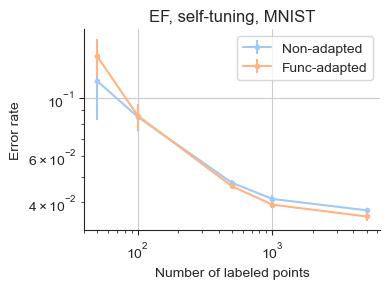

In [41]:
# plot the error rate vs. number of labeled points for all numbers of images, using the best number of eigenfunctions for each point
out_dir = 'mnist/FA/'
# create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

with h5py.File(oj(out_dir, 'total{}.h5'.format(num_total)), 'r') as hf:
    error_rate_NA_array = hf['test_error_rate_NA_array'][:]
    error_rate_FA_array = hf['test_error_rate_FA_array'][:]
    num_labeled_list = hf['num_labeled_list'][:]

error_rate_NA_mean = np.mean(error_rate_NA_array, axis=1)
error_rate_NA_std = np.std(error_rate_NA_array, axis=1)
error_rate_FA_mean = np.mean(error_rate_FA_array, axis=1)
error_rate_FA_std = np.std(error_rate_FA_array, axis=1)

ax.errorbar(num_labeled_list, error_rate_NA_mean, yerr=error_rate_NA_std, fmt='.-', label="Non-adapted")
ax.errorbar(num_labeled_list, error_rate_FA_mean, yerr=error_rate_FA_std, fmt='.-', label="Func-adapted")

ax.set_xlabel("Number of labeled points")
ax.set_ylabel("Error rate")
# set log scale for x axis
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.grid('on')
ax.set_title('EF, self-tuning, MNIST')
sns.despine()
fig.tight_layout()

In [50]:
### Run time comparison ###
import time
def single_run_time(data, labels, num_labeled, k, j, sigma, beta, steps, num_eigenvectors, type):
    num_total = data.shape[0]
    # randomly choose num_labeled points as labeled data
    indices = np.random.permutation(num_total) # Randomly selected labeled points
    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]

    # construct the graph
    s = time.process_time()
    W, indices, distances = construct_graph(data, k, j, sigma)
    

    if type == 'FA':
        # compute random walk matrix K
        K = random_walk_K(W)

        # run harmonic classifier
        c = harmonic_classifier_one_vs_all(labels, labeled_indices, K, steps=steps)

        # compute the function-adapted weight matrix
        W = function_adapted_W(data, c, indices, j, sigma, beta=beta)

    time_graph_construction = time.process_time() - s

    # compute the graph Laplacian and eigenfunctions
    s = time.process_time()
    L = compute_graph_laplacian(W)
    eigenvalues, eigenvectors = compute_eigenfunctions(L, num_eigenvectors)
    time_eigenfunctions = time.process_time() - s

    # train the classifiers
    s = time.process_time()
    X = eigenvectors
    y = labels

    classifiers = train_one_vs_all_classifiers(X, y, labeled_indices)

    # evaluate the classifiers
    y_pred, y_score = predict_one_vs_all_classifiers(classifiers, X[unlabeled_indices])
    accuracy = compute_classification_accuracy(y[unlabeled_indices], y_pred)
    time_classification = time.process_time() - s

    return time_graph_construction, time_eigenfunctions, time_classification
    

    
# compare the run time of the function-adapted algorithm and the non-adapted algorithm
num_total_list = [10000]

# load pca reduced mnist data
data_full = np.load('myDataSets/mnist/pca_smoothed_data.npy')
labels_full = np.load('myDataSets/mnist/labels.npy')
data = data_full[30000:30000+num_total]
labels = labels_full[30000:30000+num_total]

# get the list of number of labeled points
num_labeled_list = get_num_labeled_list(num_total)
num_splits = 5

# set algorithm parameters
k = 9
j = 4
sigma = 1
beta = 1
steps = 250

run_time_NA_array = np.zeros((len(num_total_list), len(get_num_labeled_list(10000))))
# run_time_FA_array = np.zeros((len(num_labeled_list),))
time_graph_construction_array = np.zeros((len(num_total_list), len(num_labeled_list)))
time_eigenfunctions_array = np.zeros((len(num_total_list), len(num_labeled_list)))
time_classification_array = np.zeros((len(num_total_list), len(num_labeled_list)))

best_num_eigenvectors = {50: 20, 100: 20, 500: 70, 1000: 150, 5000: 250}

for i_ntotal, num_total in enumerate(num_total_list):
    print("Number of total points: {}".format(num_total))
    num_labeled_list = get_num_labeled_list(num_total)
    for i_nlb, num_labeled in enumerate(num_labeled_list):
        num_eigenvectors = best_num_eigenvectors[num_labeled]
        
        print("Number of labeled points: {}, Number of eigenfunctions: {}".format(num_labeled, num_eigenvectors))

        run_time_NA = 0
        time_graph_construction = 0
        time_eigenfunctions = 0
        time_classification = 0
        for _ in range(num_splits):
            # s = time.process_time()
            time_graph_construction_, time_eigenfunctions_, time_classification_ = single_run_time(data, labels, num_labeled, k, j, sigma, beta, steps, num_eigenvectors, type='NA')
            # run_time_NA += time.process_time() - s
            time_graph_construction += time_graph_construction_
            time_eigenfunctions += time_eigenfunctions_
            time_classification += time_classification_


        run_time_NA /= num_splits
        time_graph_construction /= num_splits
        time_eigenfunctions /= num_splits
        time_classification /= num_splits

        

        

        # s = time.time()
        # single_run_time(data, labels, num_labeled, k, j, sigma, beta, steps, num_eigenvectors, type='FA')
        # run_time_FA = time.time() - s

        run_time_NA_array[i_ntotal, i_nlb] = run_time_NA
        # run_time_FA_array[i_nlb] = run_time_FA
        time_graph_construction_array[i_ntotal, i_nlb] = time_graph_construction
        time_eigenfunctions_array[i_ntotal, i_nlb] = time_eigenfunctions
        time_classification_array[i_ntotal, i_nlb] = time_classification

        print("Number of labeled points: {}".format(num_labeled))
        print("Run time of non-adapted algorithm: {}".format(run_time_NA))
        # print("Run time of function-adapted algorithm: {}".format(run_time_FA))
        print("Time for graph construction: {}".format(time_graph_construction))
        print("Time for computing eigenfunctions: {}".format(time_eigenfunctions))
        print("Time for classification: {}".format(time_classification))
        

# save the results to h5 file
with h5py.File('run_time_comparison.h5', 'w') as f:
    f.create_dataset('num_total_list', data=num_total_list)
    f.create_dataset('num_labeled_list', data=num_labeled_list)
    f.create_dataset('run_time_NA_array', data=run_time_NA_array)
    # f.create_dataset('run_time_FA_array', data=run_time_FA_array)
    f.create_dataset('time_graph_construction_array', data=time_graph_construction_array)
    f.create_dataset('time_eigenfunctions_array', data=time_eigenfunctions_array)
    f.create_dataset('time_classification_array', data=time_classification_array)




Number of total points: 10000
Number of labeled points: 50, Number of eigenfunctions: 20
Number of labeled points: 50
Run time of non-adapted algorithm: 0.0
Time for graph construction: 80.62008047400013
Time for computing eigenfunctions: 0.29664939460089956
Time for classification: 0.0029599980007333215
Number of labeled points: 100, Number of eigenfunctions: 20
Number of labeled points: 100
Run time of non-adapted algorithm: 0.0
Time for graph construction: 80.76707426500033
Time for computing eigenfunctions: 0.2843360740003845
Time for classification: 0.00304691220044333
Number of labeled points: 500, Number of eigenfunctions: 70
Number of labeled points: 500
Run time of non-adapted algorithm: 0.0
Time for graph construction: 81.81789154180042
Time for computing eigenfunctions: 1.2482983193996915
Time for classification: 0.017692291400089745
Number of labeled points: 1000, Number of eigenfunctions: 150
Number of labeled points: 1000
Run time of non-adapted algorithm: 0.0
Time for gr

In [51]:
run_time_NA_array.shape

(1, 5)

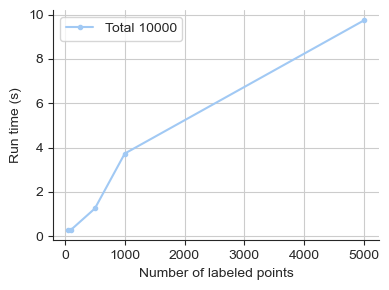

In [55]:
# plot run time vs. number of labeled points
out_dir = 'mnist/FA/'
# create figure and axes
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
for i_ntotal, num_total in enumerate(num_total_list):
    num_labeled_list = get_num_labeled_list(num_total)
    ax.plot(num_labeled_list, time_eigenfunctions_array[i_ntotal], '.-', label="Total {}".format(num_total))

ax.set_xlabel("Number of labeled points")
ax.set_ylabel("Run time (s)")
# set log scale for x axis
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend()
ax.grid('on')
# ax.set_title('EF, self-tuning, MNIST')
sns.despine()

fig.tight_layout()